# Control and Grid

Implementation of the basic control and the grid generator classes working together.

Use simulation:

- complex_1.ttt

In [1]:
# Imports
import time
import math as m
import numpy as np
import matplotlib.pyplot as plt

# API Functions
# https://www.coppeliarobotics.com/helpFiles/en/zmqRemoteApiOverview.htm
# https://www.coppeliarobotics.com/helpFiles/en/apiFunctions.htm
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print("Ready.")

Ready.


# Occupancy Grid


In [2]:
class OccupancyMap:
    def __init__(self, map_size):
        self.map_resolution = 0.05
        self.map_size = map_size
        self.grid_size = int(self.map_size / self.map_resolution)
        self.occupancy_map = np.zeros((self.grid_size, self.grid_size))

    def update_map(self, measurements):
        for measurement in measurements:
            # Note: 'x' and 'y' are flipped because the grid
            # representation has x on a different axis
            y = int(measurement[0] / self.map_resolution)
            x = int(measurement[1] / self.map_resolution)
            # Maybe set the likelihood proportional to the measurement
            log_likelihood = np.log(0.8)
            self.occupancy_map[x, y] += log_likelihood

    def create_window_from_coordinates(self, coord_a, coord_b):
        num_cells_y, num_cells_x = self.occupancy_map.shape

        # Convert the window coordinates to grid indices
        xmin = int(coord_a[0] / self.map_resolution)
        xmax = int(coord_b[0] / self.map_resolution)
        ymin = int(coord_a[1] / self.map_resolution)
        ymax = int(coord_b[1] / self.map_resolution)

        # Clip the coordinates to valid grid indices
        xmin = max(xmin, 0)
        xmax = min(xmax, num_cells_x - 1)
        ymin = max(ymin, 0)
        ymax = min(ymax, num_cells_y - 1)

        # Extract the window from the occupancy grid
        ret = self.occupancy_map[ymin:ymax + 1, xmin:xmax + 1]
        return 1 - np.exp(ret)

    def normalize_log_probabilities(self):
        """"
        Normalize the probabilities so very small values exist.
        Do not use if a lof of the values are zero since they will turn into something larger.
        Use this IF you include a full ray measurement, aka, you set empty cells as empty across the ray and occupied where it hits.
        """
        self.occupancy_map = self.occupancy_map - np.logaddexp(self.occupancy_map, 0)

    def print_map(self):
        probabilities = np.exp(self.occupancy_map)
        print(probabilities)

    def plot_map(self):
        plt.imshow(self.occupancy_map, origin='lower', cmap='gray')
        plt.colorbar()
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Occupancy Grid (log odds)')
        plt.show()

    def plot_map_normal(self):
        probabilities = 1 - np.exp(self.occupancy_map)
        plt.imshow(probabilities, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
        plt.colorbar()
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Occupancy Grid')
        plt.show()


In [3]:
def calculate_square_coordinates(center, side):
    """
    Calculate the coordinates of a square given a center point and the size of its side.

    Parameters:
    center (tuple): The center point of the square in the form (x, y).
    side (float): The size of the side of the square.

    Returns:
    tuple: A tuple containing two coordinate pairs representing the square.
           The first pair represents the bottom-left corner (x1, y1),
           and the second pair represents the top-right corner (x2, y2).
    """
    half_side = side / 2

    x_center, y_center = center

    x1 = x_center - half_side
    y1 = y_center - half_side

    x2 = x_center + half_side
    y2 = y_center + half_side

    return (x1, y1), (x2, y2)


center = (1, 1)
side = 2

a, b = calculate_square_coordinates(center, side)
print("a =", a)
print("b =", b)

a = (0.0, 0.0)
b = (2.0, 2.0)


# Simulation and Control

In [4]:
class P3DXSim:
    def __init__(self):
        self.client = RemoteAPIClient()
        self.client.setStepping(False)
        self.doStepping = False
        self.sim = self.client.getObject('sim')
        self.motorL = self.sim.getObject("/PioneerP3DX/leftMotor")
        self.motorR = self.sim.getObject("/PioneerP3DX/rightMotor")
        self.robot = self.sim.getObject("/PioneerP3DX")
        self.r = 0.5 * 0.195
        self.L = 2.0 * 0.1655
        self.ptArray = []
        self.orientation = self.get_orientation()
        self.position = self.get_pos()

    def v2u(self, v, omega):
        ur = v / self.r + self.L * omega / (2 * self.r)
        ul = v / self.r - self.L * omega / (2 * self.r)
        return ur, ul

    def stepping(self, val=True):
        self.client.setStepping(val)
        self.doStepping = val

    def do_step(self):
        self.client.step()

    def set_velocity(self, ur, ul):
        self.sim.setJointTargetVelocity(self.motorL, ul)
        self.sim.setJointTargetVelocity(self.motorR, ur)

    def move_vel(self, vel=0, w=0):
        ur, ul = self.v2u(vel, w)
        self.set_velocity(ur, ul)

    def move_backwards(self):
        ur, ul = self.v2u(-0.25, 0)
        self.set_velocity(ur, ul)

    def move_forward(self):
        ur, ul = self.v2u(0.25, 0)
        self.set_velocity(ur, ul)

    def exec_action_time(self, e_time, action, *args):
        print(f"Executing {action.__name__}{args} for {e_time}seconds.")
        s_time = self.sim.getSimulationTime()
        while self.sim.getSimulationTime() < s_time + e_time:
            action(*args)
        # Stop moving
        ur, ul = self.v2u(0, 0)
        self.set_velocity(ur, ul)

    def rotate_until_ori_rad(self, d_ori_rad, speed_ratio):
        c_ori_rad = self.get_euler()[-1]
        eps_deg = 5.0
        eps_rad = eps_deg * ((2 * np.pi) / 360.0)
        a_lim = d_ori_rad - (eps_rad / 2.0)
        b_lim = d_ori_rad + (eps_rad / 2.0)
        omega = 2.0 * np.pi  # 360deg in rad
        print(np.rad2deg([eps_rad, a_lim, b_lim, c_ori_rad]))
        while not (a_lim <= c_ori_rad < b_lim):
            self.orientation = self.get_orientation()
            print(f"Orientation: {self.orientation}")
            self.move_vel(0, omega / speed_ratio)
            c_ori_rad = self.get_euler()[-1]
        # Stop moving
        ur, ul = self.v2u(0, 0)
        self.set_velocity(ur, ul)
        print(f"Orientation: {self.orientation}")

    def start(self):
        if self.sim.startSimulation():
            print("Started simulation.")

    def stop(self):
        if self.sim.stopSimulation():
            print("Stopped simulation.")

    def pause(self):
        if self.sim.pauseSimulation():
            print("Paused simulation.")

    def print_data_block_tags(self):
        print(self.sim.readCustomDataBlockTags(self.sim.handle_scene))

    def update_data_block(self):
        self.ptArray = self.sim.readCustomTableData(self.sim.handle_scene, 'ptArray')

    def get_pos(self):
        return self.sim.getObjectPosition(self.robot, -1)

    def get_euler(self):
        return self.sim.getObjectOrientation(self.robot, -1)

    def get_orientation(self):
        return np.rad2deg(self.get_euler()[-1])


## Intit and execute


In [5]:
robot = P3DXSim()

In [6]:
robot.stepping(False)

In [ ]:
robot.stepping(True)

In [7]:
robot.start()

Started simulation.


In [ ]:
robot.pause()

In [ ]:
robot.stop()

In [ ]:
robot.do_step()

In [8]:
robot.get_pos()

[2.6696565847699296, 2.5398724085776334, 0.13865442748777215]

In [9]:
robot.get_euler()

[-2.9185469845097334e-05, -0.00277643070349209, 0.017494501714903753]

In [10]:
robot.get_orientation()

1.0021250634533057

## Sample Actions


In [ ]:
robot.move_forward()

In [ ]:
robot.move_backwards()

In [ ]:
robot.exec_action_time(3.0, robot.move_vel, 0.25)

In [ ]:
# Back
robot.exec_action_time(3.0, robot.move_vel, -0.25)

In [ ]:
# Left
robot.exec_action_time(3.0, robot.move_vel, 0.25, 2.0 * m.pi / 15.0)

In [ ]:
# Right
robot.exec_action_time(3.0, robot.move_vel, 0.25, -2.0 * m.pi / 15.0)

In [ ]:
# Rotate in place
robot.exec_action_time(3.0, robot.move_vel, 0.0, 2.0 * m.pi / 15.0)

In [ ]:
# Rotate until reaches close to a orientation (radians)
robot.rotate_until_ori_rad(np.deg2rad(15), 30)

In [ ]:
# Stop
robot.exec_action_time(0.0, robot.move_vel, 0)

## Read Sensor Data

In [11]:
robot.print_data_block_tags()

['myTag', '__info__', 'ptArray']


In [12]:
robot.update_data_block()
robot.ptArray[0]

[2.920721065629173, 0.4500000007450522, 0.11817092924115213]

In [13]:
# Certainty Map
occupancy_map = OccupancyMap(map_size=10.0)

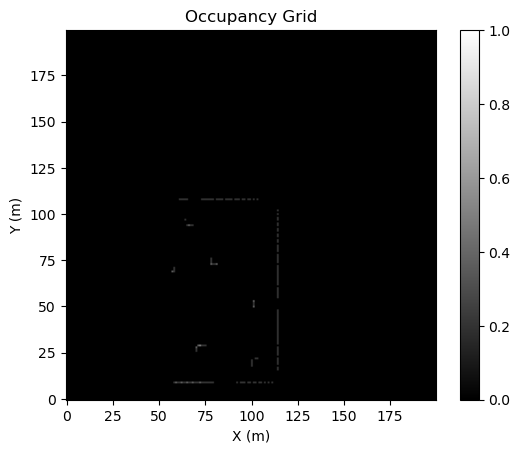

In [14]:
# Update map
occupancy_map.update_map(robot.ptArray)

# Plot
occupancy_map.plot_map_normal()

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


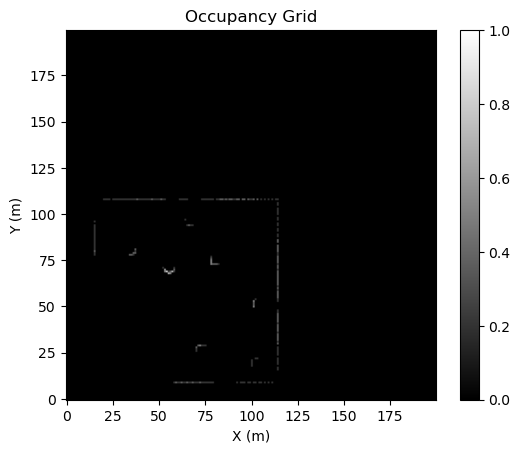

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


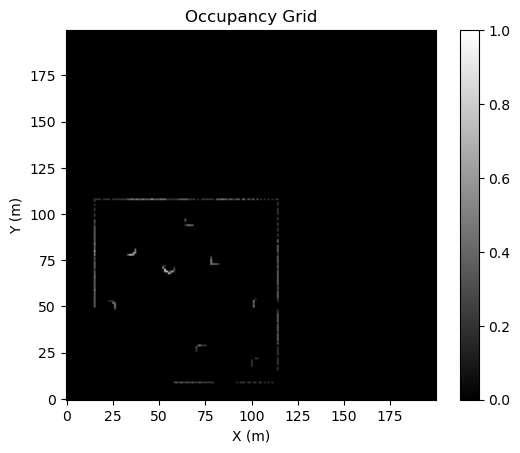

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


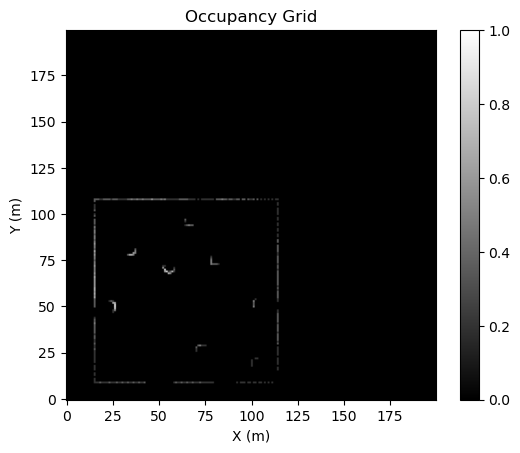

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


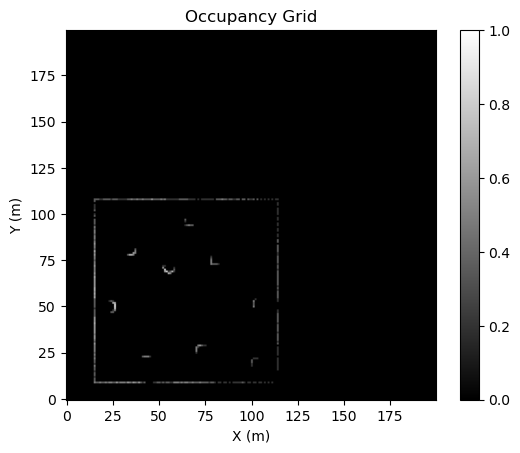

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


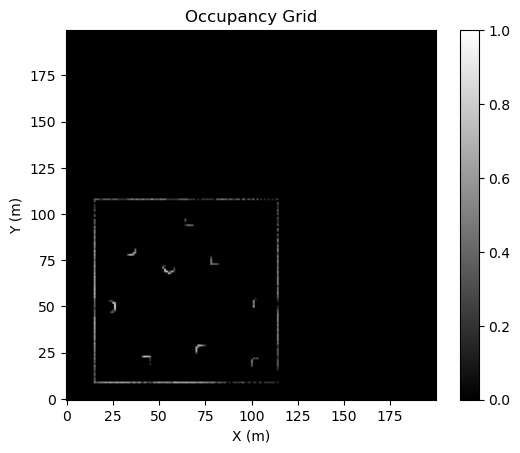

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


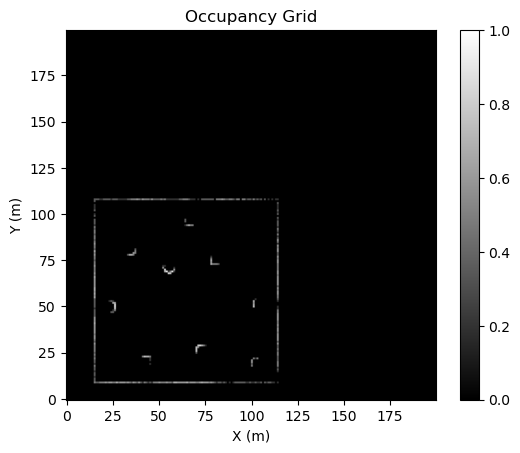

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


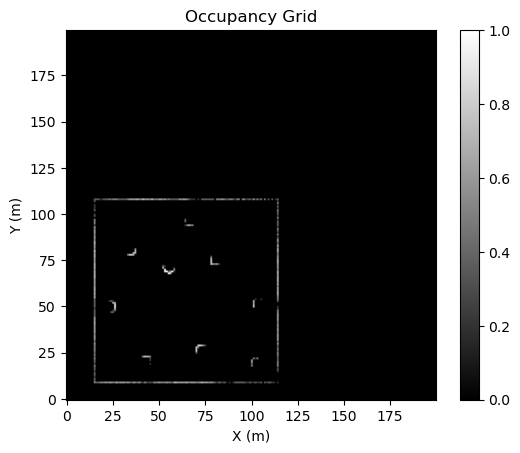

Executing move_vel(-0.25,) for 3.0seconds.
Executing move_vel(0.25, 0.41887902047863906) for 3.0seconds.


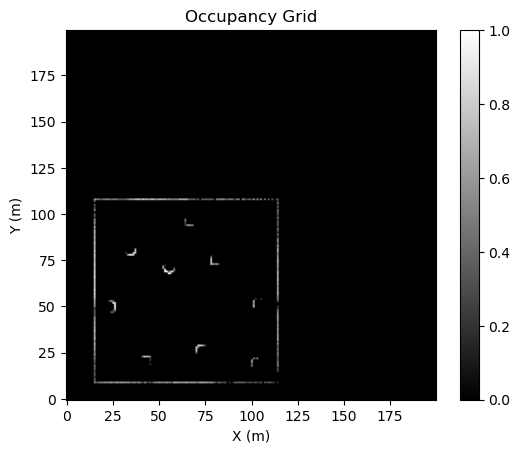

In [15]:
for i in range(8):
    # Back
    robot.exec_action_time(3.0, robot.move_vel, -0.25)
    # Left
    robot.exec_action_time(3.0, robot.move_vel, 0.25, 2.0 * m.pi / 15.0)
    # Update sensor data block
    robot.update_data_block()
    # Update map
    occupancy_map.update_map(robot.ptArray)
    # Plot
    occupancy_map.plot_map_normal()


# Create Window

In [16]:
position = robot.get_pos()
position

[2.123784300565804, 2.8139565524400845, 0.13870401242748592]

In [17]:
center = (position[0], position[1])
side = 2.0
a, b = calculate_square_coordinates(center, side)
print("a =", a)
print("b =", b)
window = occupancy_map.create_window_from_coordinates(a, b)

a = (1.123784300565804, 1.8139565524400845)
b = (3.123784300565804, 3.8139565524400845)


In [18]:
window

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
def plot_window(window):
    plt.imshow(window, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xlabel('X (cells)')
    plt.ylabel('Y (cells)')
    plt.title('Occupancy Grid (5cm)')
    plt.show()

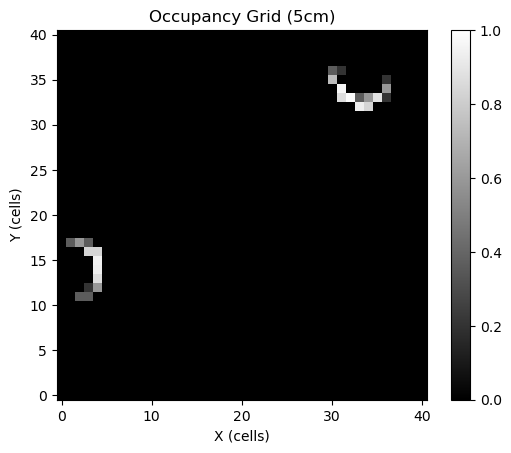

In [21]:
plot_window(window)

In [22]:
window

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Vector Grid Map

In [23]:
def calculate_magnitude(certainty, cte_a, cte_b, distance):
    return (certainty * certainty) * (cte_a - cte_b * distance)


def calculate_dir(x0, y0, xi, yj):
    """"
    Returns angle in radians
    x0, y0: coordinates of the VCP (vehicle center point)
    xi, yj: coordinates of the cell
    """
    return np.arctan2([yj - y0], [xi - x0])


def calculate_cell_distance(i, j, vcp, sz):
    c_x = i * sz
    c_y = j * sz
    c_a = np.array([c_x, c_y])
    return np.linalg.norm(c_a - vcp)


def calculate_cell_cell_distance(i0, j0, i1, j1, sz):
    cell_index1 = (i0, j0)  # Indices of the first cell
    cell_index2 = (i1, j0)  # Indices of the second cell
    distance = np.linalg.norm(np.array(cell_index2) - np.array(cell_index1)) * sz
    return distance


def find_closest_cell_center(map_size):
    # Calculate the center coordinates
    center_row = (map_size - 1) / 2
    center_col = (map_size - 1) / 2

    # Round the center coordinates to the nearest integer
    center_row = int(round(center_row))
    center_col = int(round(center_col))

    # Return the coordinates of the cell closest to the center
    return center_row, center_col



In [24]:
class VectorGridMap:
    def __init__(self, map_size):
        self.map_resolution = 0.05  # Cell size in meters
        self.map_size = map_size  # Side in meters of the side of the square
        self.grid_size = int(self.map_size / self.map_resolution)  # Number of cells per side
        self.vector_map = np.zeros((self.grid_size, self.grid_size),
                                   dtype=[('x', 'float64'), ('y', 'float64')])  # Magnitude and direction
        self.component_map = np.zeros((self.grid_size, self.grid_size),
                                      dtype=[('x', 'float64'), ('y', 'float64')])  # For the quiver plot
        self.positional_angle_map = np.zeros((self.grid_size, self.grid_size),
                                             dtype='float64')  # For the quiver plot
        self.max_magnitude = 0.0  # Careful when not updating this
        self.vcp = np.array([map_size / 2, map_size / 2])
        self.vcp_x, self.vcp_y = find_closest_cell_center(self.grid_size)  # Cell coordinates of the VCP
        self.d_max = np.sqrt(2.0) * (map_size / 2.0)  # Max distance between VCP and any other cell in the grid
        # Note: Both should balance so (a) = -(b)(d)
        self.b = 1.0  # Constant
        self.a = self.b * self.d_max  # Constant
        self.n_bins = 72
        self.bins = np.zeros(self.n_bins, dtype='float64')
        self.bin_range = 360.0 / self.n_bins

    def update_component_map(self, idx_i, idx_j, magnitude, direction):
        self.component_map[idx_i, idx_j] = (
            magnitude * np.cos(direction), magnitude * np.sin(direction))
        if magnitude > self.max_magnitude:
            self.max_magnitude = magnitude

    def init_with_window(self, window_data):
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # Magnitude of the "force" ||F||
                mag = calculate_magnitude(window_data[i, j], self.a, self.b,
                                          calculate_cell_cell_distance(i, j, self.vcp_x, self.vcp_y,
                                                                       self.map_resolution))
                # Direction of the vector (radians)
                beta = calculate_dir(self.vcp_x, self.vcp_y, i, j)
                # Insert data in the vector map
                self.vector_map[i, j]['x'] = mag
                self.vector_map[i, j]['y'] = beta
                # Update the data in the component map (to draw the quiver plot only)
                self.update_component_map(i, j, mag, beta)
                # Calculate the positional angle
                angle = np.degrees(np.arctan2(j - self.vcp_y, i - self.vcp_x))
                self.positional_angle_map[i, j] = angle
                # self.positional_angle_map[j, i] = angle

    def assign_cell_to_bin(self):
        # Create array of bin limits
        bin_limits = np.linspace(-180, 180, self.n_bins + 1)
        # Assign values to bins
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # NOTE: Unroll this loop using a hash map for the desired angles instead of iterating over all bins
                value = self.positional_angle_map[i][j]
                for k in range(num_bins):
                    if bin_limits[k] <= value < bin_limits[k + 1]:
                        self.bins[k] += self.vector_map[i, j]['x']
                        break

        return bins

    def plot_map(self):
        x = np.arange(0, self.map_size, self.map_resolution)
        y = np.arange(0, self.map_size, self.map_resolution)
        X, Y = np.meshgrid(x, y)

        U = self.component_map['x']
        V = self.component_map['y']

        plt.quiver(X, Y, U, V, scale=50)
        plt.title('Vector Field Map')
        plt.show()

In [25]:
def plot_window_vector(window_vector):
    plt.imshow(window_vector['x'], origin='lower', cmap='gray')
    plt.colorbar()
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Magnitude Map')
    plt.show()

In [26]:
# Example usage
vector_map = VectorGridMap(map_size=side)

In [27]:
vector_map.init_with_window(window)
vector_map.vector_map.shape


(40, 40)

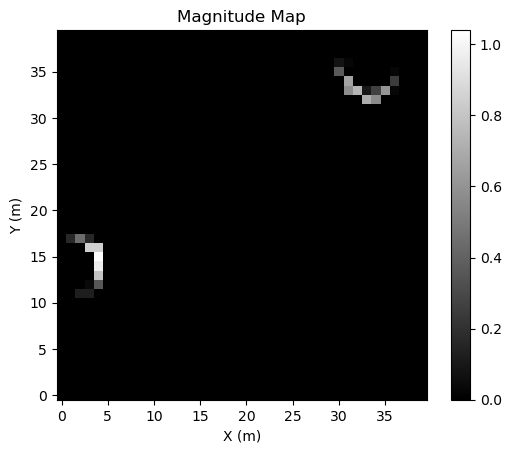

2.0


In [29]:
plot_window_vector(vector_map.vector_map)
print(vector_map.map_size)

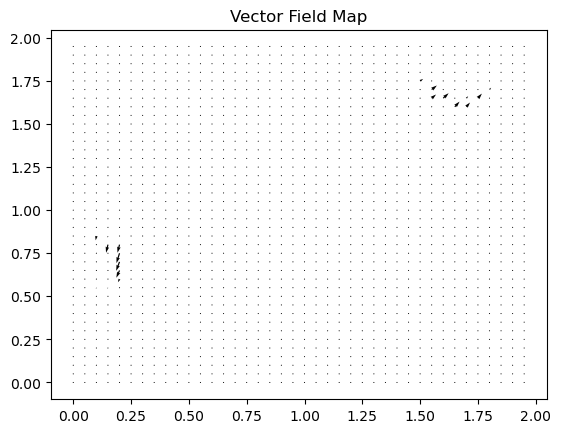

In [31]:
# Plot
vector_map.plot_map()


In [32]:
vector_map.positional_angle_map

array([[-135.        , -136.46880071, -138.0127875 , ...,  139.63546343,
         138.0127875 ,  136.46880071],
       [-133.53119929, -135.        , -136.5481577 , ...,  138.17983012,
         136.5481577 ,  135.        ],
       [-131.9872125 , -133.4518423 , -135.        , ...,  136.63657704,
         135.        ,  133.4518423 ],
       ...,
       [ -49.63546343,  -48.17983012,  -46.63657704, ...,   45.        ,
          46.63657704,   48.17983012],
       [ -48.0127875 ,  -46.5481577 ,  -45.        , ...,   43.36342296,
          45.        ,   46.5481577 ],
       [ -46.46880071,  -45.        ,  -43.4518423 , ...,   41.82016988,
          43.4518423 ,   45.        ]])

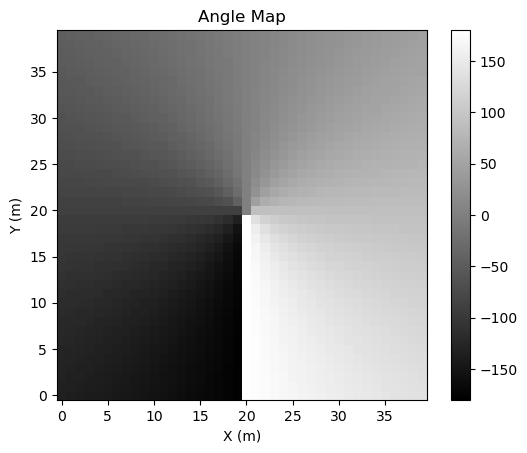

In [33]:
plt.imshow(vector_map.positional_angle_map, origin='lower', cmap='gray', vmax=180, vmin=-180)
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Angle Map')
plt.show()

In [34]:
def assign_to_bins_grid(values_grid, num_bins):
    total_range = 360.0
    bin_size = total_range / num_bins

    # Create array of bin limits
    bin_limits = np.linspace(-180, 180, num_bins + 1)

    # Initialize empty bins
    bins = [[] for _ in range(num_bins)]

    # Assign values to bins
    for x in values_grid:
        for value in x:
            for i in range(num_bins):
                if bin_limits[i] <= value < bin_limits[i + 1]:
                    bins[i].append(value)
                    break

    return bins


In [35]:
# Example usage
num_bins = 72

bins = assign_to_bins_grid(vector_map.positional_angle_map, num_bins)

# Print the bins and their contents
print(f"Bin first: {bins[0]}")
print(f"Bin last : {bins[-1]}")


Bin first: [-177.13759477388825, -176.98721249581666, -176.82016988013575, -176.63353933657018, -176.42366562500266, -176.18592516570965, -175.91438322002512, -175.6012946450045, -175.2363583092738]
Bin last : [177.13759477388825, 176.98721249581666, 176.82016988013575, 176.63353933657018, 176.42366562500266, 176.18592516570965, 175.91438322002512, 175.6012946450045, 175.2363583092738]


In [36]:
vector_map.assign_cell_to_bin()


[[-177.13759477388825,
  -176.98721249581666,
  -176.82016988013575,
  -176.63353933657018,
  -176.42366562500266,
  -176.18592516570965,
  -175.91438322002512,
  -175.6012946450045,
  -175.2363583092738],
 [-171.46923439005187,
  -174.28940686250036,
  -171.0273733851036,
  -173.99099404250546,
  -170.53767779197437,
  -173.6598082540901,
  -173.29016319224309,
  -172.8749836510982,
  -172.40535663140858,
  -171.86989764584402,
  -171.2538377374448,
  -170.53767779197437,
  -174.8055710922652,
  -174.28940686250036,
  -173.6598082540901,
  -172.8749836510982,
  -171.86989764584402,
  -170.53767779197437],
 [-165.96375653207352,
  -168.6900675259798,
  -165.25643716352928,
  -168.11134196037204,
  -167.47119229084848,
  -166.75948008481282,
  -169.9920201985587,
  -165.96375653207352,
  -169.38034472384487,
  -165.06858282186246,
  -168.6900675259798,
  -167.90524292298792,
  -167.0053832080835,
  -165.96375653207352,
  -169.69515353123398,
  -168.6900675259798,
  -167.47119229084848,


In [37]:
vector_map.bins

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.64401931, 1.76405102, 1.03972555,
       1.84577842, 0.60451173, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.46578939, 0.6648394 , 1.30976626,
       2.51994071, 0.03056854, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [38]:
bin_limits = np.linspace(-180, 180, num_bins)
bin_limits_rad = np.deg2rad(bin_limits)


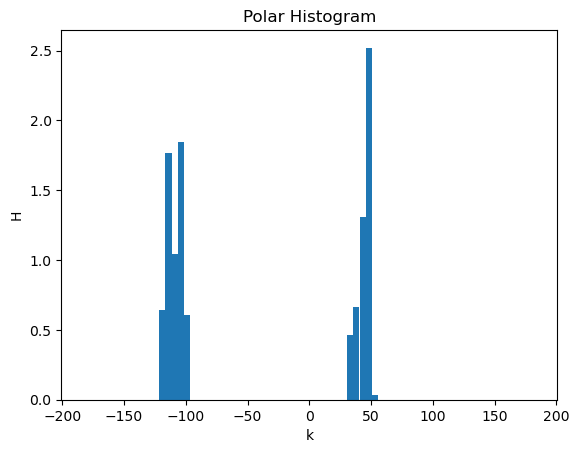

In [39]:
x = np.linspace(0, 360, vector_map.n_bins)
plt.bar(bin_limits, vector_map.bins, width=vector_map.bin_range, align='center')
plt.xlabel('k')
plt.ylabel('H')
plt.title('Polar Histogram')
plt.show()


In [40]:
from scipy.ndimage import uniform_filter1d

N = 3
eps = 1e-14
ufd = uniform_filter1d(vector_map.bins, size=N, mode='wrap')
ufd[np.abs(ufd) < eps] = 0.0  # Remove extremely low values

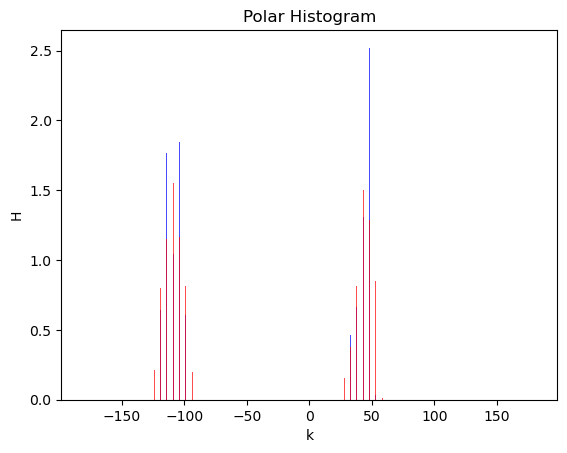

In [42]:
plt.bar(bin_limits, vector_map.bins, color='blue', alpha=0.7)
plt.bar(bin_limits, ufd, color='red', alpha=0.7)
plt.xlabel('k')
plt.ylabel('H')
plt.title('Polar Histogram')
plt.show()


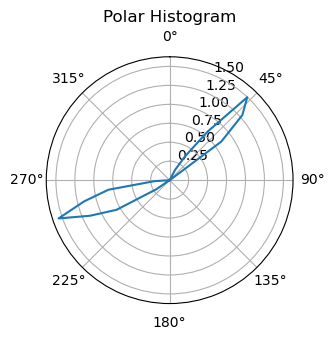

In [43]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = plt.subplot(1, 1, 1, projection='polar')
ax.set_title("Polar Histogram")
ax.set_theta_direction(-1)
ax.set_theta_offset((1 / 2) * np.pi)
# theta = np.linspace(0, 2 * np.pi, 72)
theta = np.linspace(0, 2 * np.pi, 72)
ax.plot(bin_limits_rad, ufd)
plt.show()

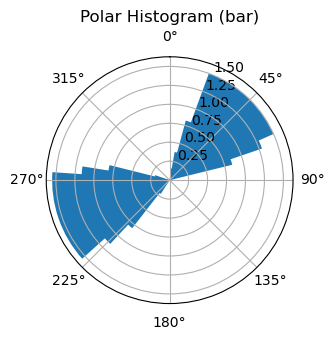

In [44]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = plt.subplot(1, 1, 1, projection='polar')
ax.set_title("Polar Histogram (bar)")
ax.set_theta_direction(-1)
ax.set_theta_offset((1 / 2) * np.pi)
# theta = np.linspace(0, 2 * np.pi, 72)
ax.bar(bin_limits_rad, ufd)
plt.show()

# Binarization

In [45]:
threshold = 0.1
h_bin = (ufd >= threshold) * 1.0
h_bin

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

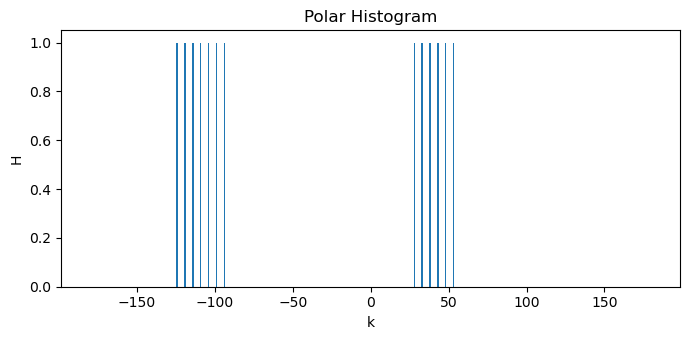

In [46]:
plt.bar(bin_limits, h_bin)
plt.xlabel('k')
plt.ylabel('H')
plt.title('Polar Histogram')
plt.show()


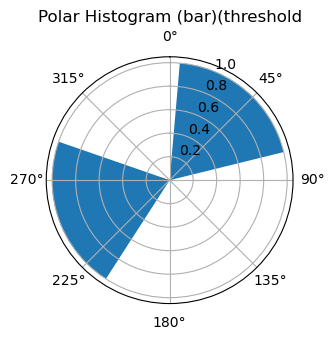

In [49]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = plt.subplot(1, 1, 1, projection='polar')
ax.set_title("Polar Histogram (bar)(threshold")
ax.set_theta_direction(-1)
ax.set_theta_offset((1 / 2) * np.pi)
ax.bar(bin_limits_rad, h_bin)
plt.show()

# Goal

In [50]:
class Goal:
    def __init__(self, sim):
        self.doStepping = False
        self.sim = sim
        self.goalObj = self.sim.getObject("/Cylinder[4]")
        self.orientation = self.get_orientation()
        self.position = self.get_pos()

    def get_pos(self):
        return self.sim.getObjectPosition(self.goalObj, -1)

    def get_euler(self):
        return self.sim.getObjectOrientation(self.goalObj, -1)

    def get_orientation(self):
        return np.rad2deg(self.get_euler()[-1])

In [51]:
goal = Goal(robot.sim)
goal.get_pos()

[5.0, 5.0, 0.25]

In [52]:
r_p = robot.get_pos()
g_p = goal.get_pos()
print(r_p, g_p)

[2.172369987841735, 2.795933948045236, 0.13867215242069877] [5.0, 5.0, 0.25]


In [53]:
rel_ang_rad = np.arctan2(g_p[0] - r_p[0], g_p[1] - r_p[1])
np.rad2deg(rel_ang_rad)

52.06448661535443

In [54]:
c_ori = robot.get_orientation()
c_ori

150.06688596888978

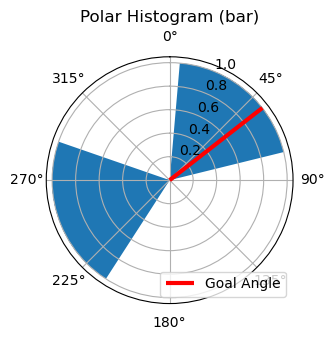

In [55]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = plt.subplot(1, 1, 1, projection='polar')
ax.set_title("Polar Histogram (bar)")
ax.set_theta_direction(-1)
ax.set_theta_offset((1 / 2) * np.pi)
ax.bar(bin_limits_rad, h_bin)
ax.vlines(rel_ang_rad, ymin=0.0, ymax=1.0, color='red', linewidth=3, label='Goal Angle')
plt.legend(loc='lower right')
plt.show()

# Valley


In [56]:
h_bin

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [60]:
def find_consecutive_zeros(arr):
    """"
    Note: Make this a circular array so the ranges wrap around
    """
    ranges = []
    start = None
    length = len(arr)

    # Iterate over the array
    for i in range(length):
        # Check if the current element is zero
        if arr[i] == 0:
            # If it's the start of a new sequence, record the index
            if start is None:
                start = i
        else:
            # If it's the end of a sequence of zeros, record the range
            if start is not None:
                ranges.append((start, i - 1))
                start = None

    # If the last element is zero, record the range
    if start is not None:
        ranges.append((start, length - 1))

    return ranges


In [61]:
consecutive = find_consecutive_zeros(h_bin)
consecutive

[(0, 10), (18, 40), (47, 71)]

In [62]:
consecutive_len = [abs(x - y) for x, y in consecutive]
consecutive_len

[10, 22, 24]

In [63]:
s_max = 18
wide = [pair for pair in consecutive if abs(pair[0] - pair[1]) > s_max]
wide

[(18, 40), (47, 71)]

In [64]:
[bin_limits[wide[0][0]], bin_limits[wide[0][1]]]

[-88.73239436619718, 22.81690140845072]

In [65]:
w_a = [[bin_limits[x[0]], bin_limits[x[1]]] for x in wide]
w_a


[[-88.73239436619718, 22.81690140845072], [58.3098591549296, 180.0]]

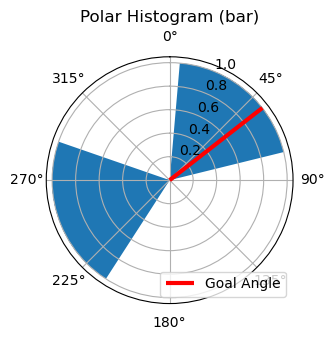

In [66]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = plt.subplot(1, 1, 1, projection='polar')
ax.set_title("Polar Histogram (bar)")
ax.set_theta_direction(-1)
ax.set_theta_offset((1 / 2) * np.pi)
ax.bar(bin_limits_rad, h_bin)
ax.vlines(rel_ang_rad, ymin=0.0, ymax=1.0, color='red', linewidth=3, label='Goal Angle')
plt.legend(loc='lower right')
plt.show()